# Hochschule Bonn-Rhein-Sieg

# Neural Networks, WS17/18

# Assignment 09 (04-December-2017)

##  Debaraj Barua, Naresh Kumar Gurulingan

In [1]:
import numpy as np
import IPython
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import math
import random

## Question 1:

Mindmap of chapter 9:

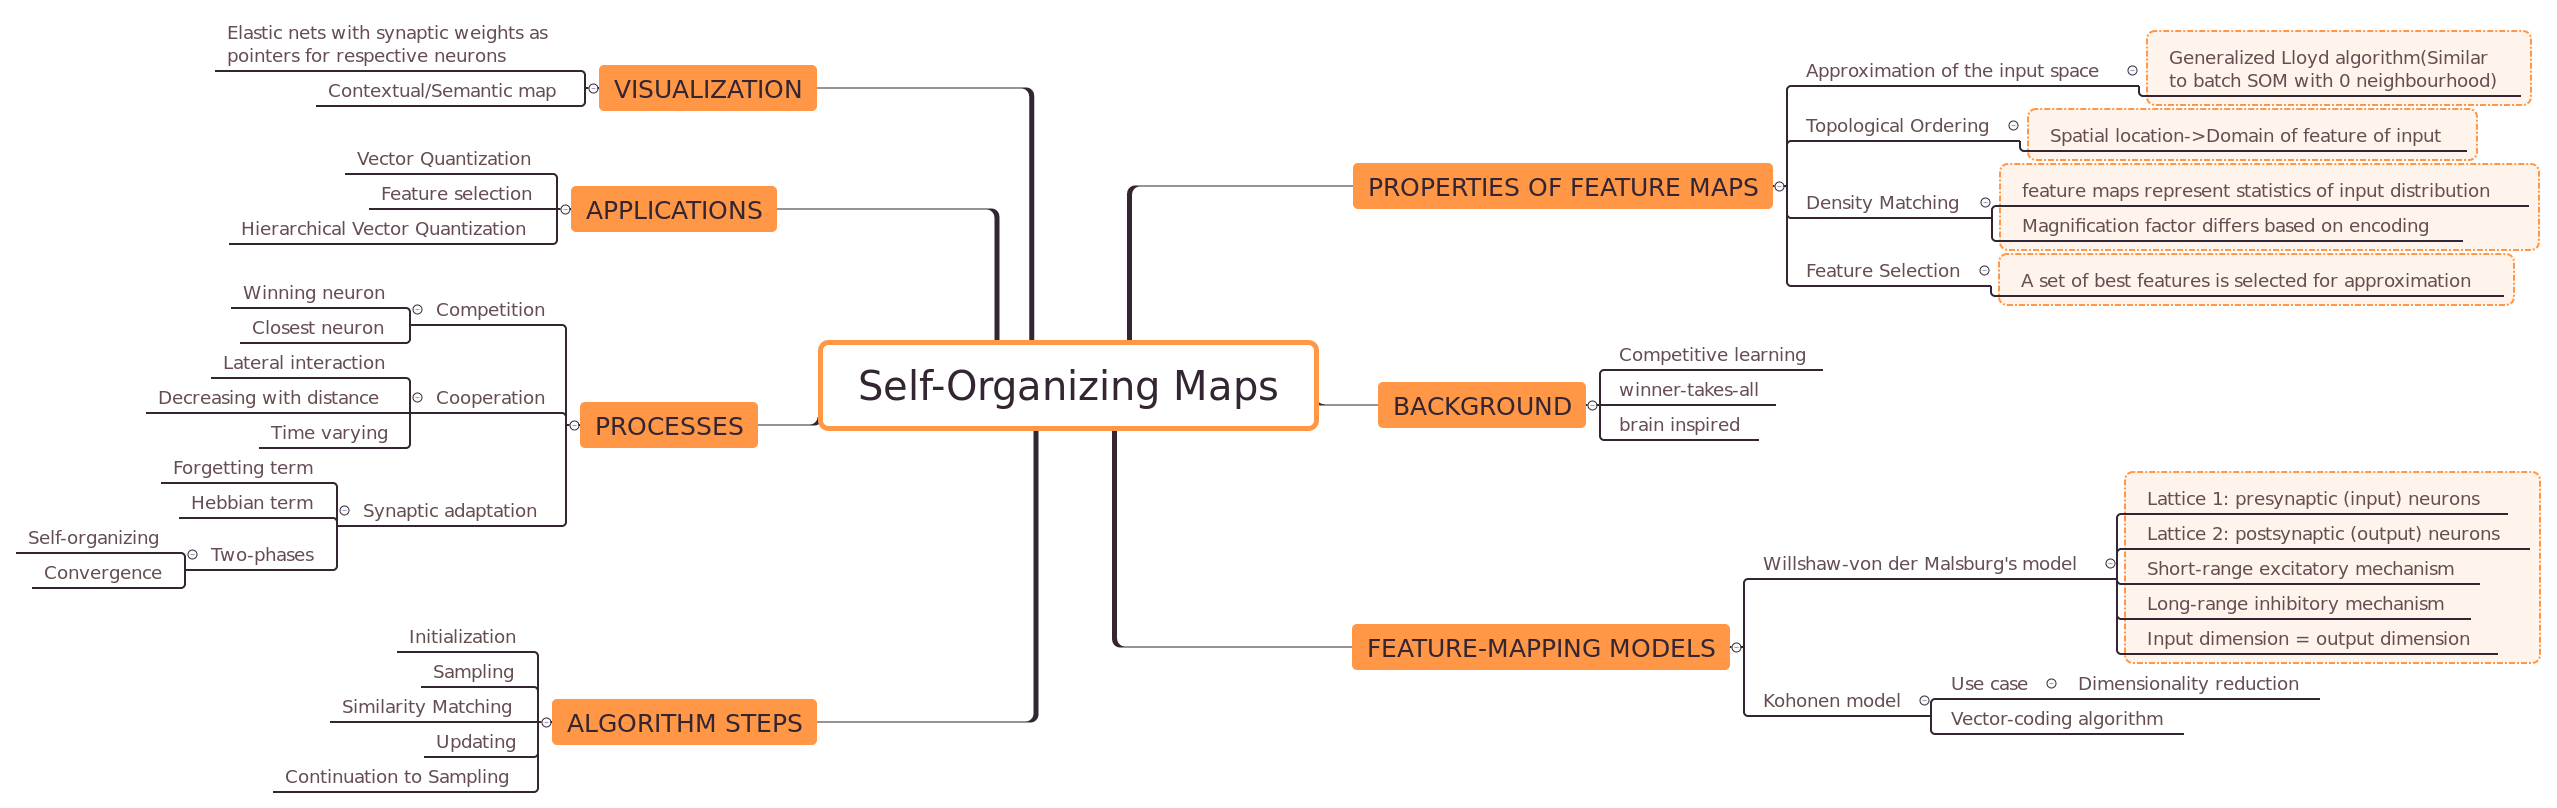

In [2]:
IPython.display.Image('images/mind_map.png')

---
## Question 2:

2) Show that in the SOM algorithm the winner neuron for an input x is that neuron k whose weight vector w_k maximizes the inner product < w_k,x > of x and wk, take x and wk as normalized.

### Answer:

SOM algorithm tries to find the winning neuron which is closest to the input sample. The closest neuron can be determined by obtaining the neuron which has the least distance from the input sample.

winning neuron k is determined by (input and weights are m dimensional):

$ k = argmin_j \lVert \mathbf{x - w_j} \rVert\\
k = argmin_j \sqrt{{(x_1 - w_{j1})}^2 + {(x_2 - w_{j2})}^2 \ldots {(x_m - w_{jm})}^2}\\
k = argmin_j \sqrt{x_1^2 + w_{j1}^2 - 2x_1\cdot w_{j1} + x_2^2 + w_{j2}^2 - 2x_2\cdot w_{j2} \ldots x_m^2 + w_{jm}^2 - 2x_m\cdot w_{jm}}\\
k = argmin_j \sqrt{x_1^2 + w_{j1}^2 + x_2^2 + w_{j2}^2 \ldots x_m^2 + w_{jm}^2 - 2x_1\cdot w_{j1} - 2x_2\cdot w_{j2} \ldots - 2x_m\cdot w_{jm}}\\
k = argmin_j \sqrt{x_1^2 + w_{j1}^2 + x_2^2 + w_{j2}^2 \ldots x_m^2 + w_{jm}^2 - 2(x_1\cdot w_{j1} + x_2\cdot w_{j2} \ldots + x_m\cdot w_{jm})}\\
k = argmin_j \sqrt{x_1^2 + w_{j1}^2 + x_2^2 + w_{j2}^2 \ldots x_m^2 + w_{jm}^2 - 2(x^T\cdot w_j)}$

It can be seen that the neuron with the largest inner product, would have the least distance (as the inner product is a negative term).

---
## Question 3:

3) Consider the one dimensional input space S={0.1, 0.2, 0.4, 0.5}. Cluster S using a one dimensional SOM network with:

– 2 nodes.

– learning rate equal to 0.1.

– Neighborhood function which is equal to 1 for the winner neuron and is 0 otherwise.

– two Weight initializations:

-- w1=0.15, w2=0.45

-- w1=0.3, w2=0.9

– Stopping criterion: (see PDF)

Comment on the two clusterings you obtained using the two different weight initializations.

In [2]:
NO_CITIES=10
XLIM=100
YLIM=100
ETA=0.1
SIGMA=8
NO_NEURONS=70
T1=1000/np.log(SIGMA)
T2=1000

In [3]:
class SOM():
    """
    SOM class used for both question 3 and 4...
    """
    def __init__(self,eta=ETA, epsilon= 0.01, is_TSA= True, 
                 weights= [0, 0], points_1d = [0, 0, 0, 0],
                 no_neurons=NO_NEURONS,no_cities=NO_CITIES
                ):
        
        self.eta=eta
        self.is_TSA = is_TSA
        self.epsilon = epsilon
        
        if is_TSA:
            self.input_vec=generate_pts(no_cities,XLIM,YLIM,typ='cities')
            self.weights=generate_pts(no_neurons,XLIM,YLIM,typ='neurons',
                                      data=self.input_vec)
        else:
            self.input_vec = np.array(points_1d)[np.newaxis].T
            self.weights = np.array(weights)[np.newaxis].T
    
    def decay_eta(self,step):
        if self.is_TSA:
            return ETA*np.exp(-step/T2)
        else:
            return ETA
    
    def decay_width(self,step):
        return SIGMA*np.exp(-step/T1)
    
    def decay_neighbours(self, step, winning_neuron, current_neuron):
        distance=cdist(winning_neuron,current_neuron)
        if self.is_TSA:
            return np.exp(-distance**2/(2*self.decay_width(step)**2))[0,0]
        else:
            return int(winning_neuron == current_neuron)
    
    def som(self,noplots=False):
        cur_iter=0
        
        if self.is_TSA and not noplots:
            plot_path(self.input_vec,self.weights,title=0,display=True)
            
        while(True):
            
            cur_iter+=1
            sample=self.input_vec[np.random.choice(len(self.input_vec), size=1, 
                                                   replace=False)]
            
            winning_neuron_idx=np.argmin(cdist(self.weights,sample))
            winning_neuron=self.weights[winning_neuron_idx][np.newaxis]
            cur_eta=self.decay_eta(cur_iter)
            old_weights = self.weights.copy()
            
            for idx, neuron in enumerate(self.weights):
                
                neuron=neuron[np.newaxis]
                cur_neighbrs=self.decay_neighbours(cur_iter,winning_neuron,neuron)
                
                self.weights[idx]+=cur_eta*cur_neighbrs*(sample-neuron)[0]
          
            if not noplots:
                if cur_iter%500==0 and self.is_TSA:
                    plot_path(self.input_vec,self.weights,title=cur_iter,
                              display=True)
                elif cur_iter%100==0 and self.is_TSA:
                    plot_path(self.input_vec,self.weights,title=cur_iter)
                
            if abs(np.linalg.norm(old_weights - self.weights)) < self.epsilon:
                break
                
        if self.is_TSA == False:
            return self.weights
        if noplots:
            return cur_iter, self.weights

In [4]:
def cluster_1d(input_space, init_weights):
    figure = plt.figure()
    figure.set_figheight(5)
    figure.set_figwidth(12)

    for i in range(6):
        som_1d = SOM(is_TSA= False, weights= init_weights, 
                    points_1d= input_space)
        clusters = som_1d.som()

        print 'Attempt :', i+1
        print 'Initial weights: ', init_weights
        print 'Resultant clusters: ', clusters.reshape(-1)
        print '---------------------------------------'

        figure.add_subplot(3, 2, i+1)
        plt.tight_layout()
        plt.scatter(input_space, [0, 0, 0, 0], color= 'k',
                   label= 'Input values')
        plt.scatter(clusters, [0, 0], color= 'r', marker= 'x', s=100,
                   label= 'Cluster results')
        plt.scatter(init_weights, [0, 0], color= 'g',
                   label= 'Initial weights')
        plt.title('Attempt :'+ str(i+1))
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.)
    plt.show()

Attempt : 1
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.145  0.45 ]
---------------------------------------
Attempt : 2
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.15   0.445]
---------------------------------------
Attempt : 3
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.155  0.45 ]
---------------------------------------
Attempt : 4
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.155  0.45 ]
---------------------------------------
Attempt : 5
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.145  0.45 ]
---------------------------------------
Attempt : 6
Initial weights:  [0.15, 0.45]
Resultant clusters:  [ 0.145  0.45 ]
---------------------------------------


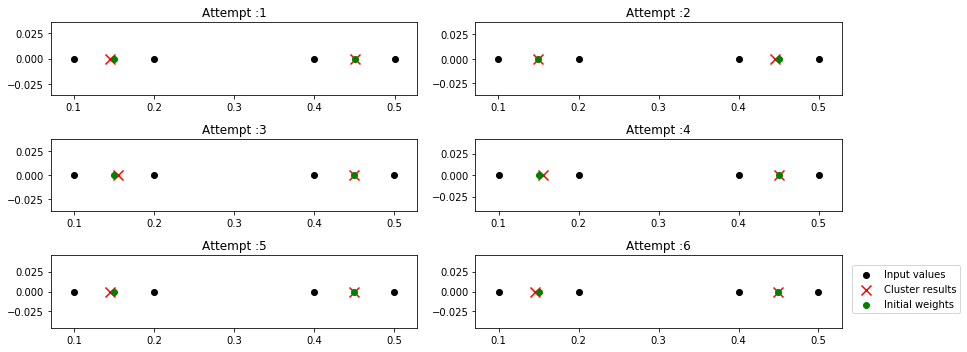

In [5]:
input_space = [0.1, 0.2, 0.4, 0.5]
init_weights = [0.15, 0.45]

cluster_1d(input_space, init_weights)

### Comments:

** Both neurons seem to have equal chances of winning as each of the neurons are close to 2 of the input samples. Thus, out of 6 attempts, the number of times each of the neurons are picked as winning neuron is similar. **

Attempt : 1
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.3299971  0.9      ]
---------------------------------------
Attempt : 2
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.319  0.9  ]
---------------------------------------
Attempt : 3
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.27848  0.9    ]
---------------------------------------
Attempt : 4
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.319  0.9  ]
---------------------------------------
Attempt : 5
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.328  0.9  ]
---------------------------------------
Attempt : 6
Initial weights:  [0.3, 0.9]
Resultant clusters:  [ 0.33071967  0.9       ]
---------------------------------------


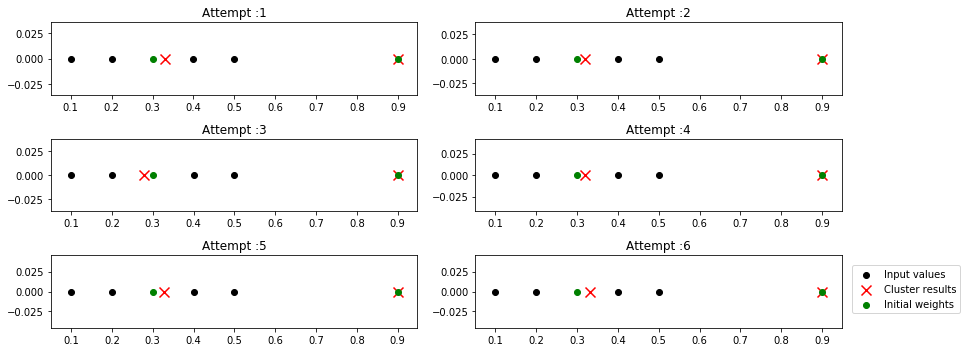

In [6]:
input_space = [0.1, 0.2, 0.4, 0.5]
init_weights = [0.3, 0.9]

cluster_1d(input_space, init_weights)

### Comments:

** The neuron with weight 0.9 is never updated after 6 attempts. This is likely becuase the neuron never wins as it is far from all the input samples when compared with the neuron with weight 0.3. **

---
## Question 4:

4) Implement a SOM to solve the traveling salesman problem (TSP)

In [12]:
def generate_pts(size,xlim,ylim,typ='cities',data=None):
    if typ=='cities':
        x=np.random.random_sample(size)*xlim
        y=np.random.random_sample(size)*ylim  
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    elif typ=='neurons':
        theta = np.array(np.linspace(0,2*np.pi,size))        
        r = random.randint(size/10,size/4)
        c_x=(np.amax(data,axis=0)[0]-np.amin(data,axis=0)[0])/2
        c_y=(np.amax(data,axis=0)[1]-np.amin(data,axis=0)[1])/2
        
        x= c_x + r * np.cos(theta) 
        y= c_y + r * np.sin(theta)        
        
        data=np.array(x)[np.newaxis].T
        data=np.hstack((data,np.array(y)[np.newaxis].T))
    return data

def plot_path(cities,weights,title=None,display=False):
    col_cities='red'
    col_weights='yellow'
    weights=np.vstack((weights,weights[0,:]))
    plt.scatter(cities[:,0],cities[:,1],label='scattered cities', 
                marker='x', color=col_cities)
    plt.plot(weights[:,0],weights[:,1],label='current path',
             marker='o',color=col_weights)
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.)
    
    if title:
        plt.title('Iteration #{:06d}'.format(title))
    
    plt.savefig('results/{}.png'.format(title))
    
    if display:
        plt.show()
    
    plt.clf()      

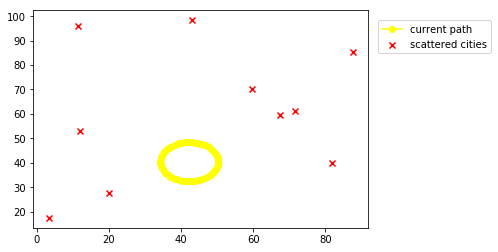

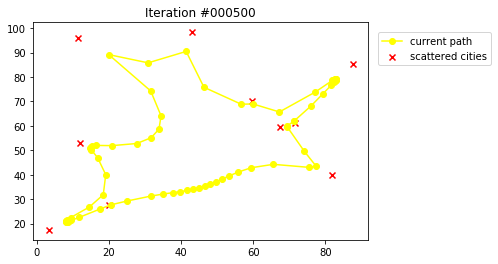

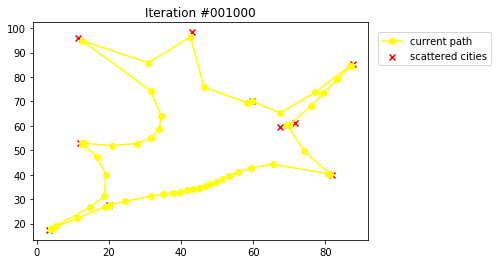

In [13]:
SOM(epsilon= 0.001).som()

### Evaluation:

We run the SOM algorithm to solve the TSP for the below mentioned scenarios:
   - For 10 cities, we change the number of neurons incrementally from 10 to 100, with increments of 10 neurons.
   - We plot the graphs between _no of neurons_ vs _path length_ and _no of neurons_ vs _no of iterations_.
   - Repeat the above steps multiple times.

In [10]:
def findPathLength(neurons):
    length=0.
    for i in xrange(neurons.shape[0]-1):
        length+=np.linalg.norm(neurons[i]-neurons[i+1])
    return length

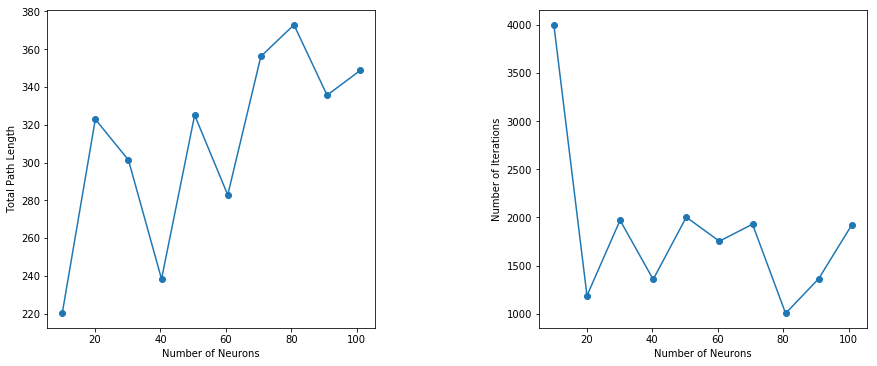

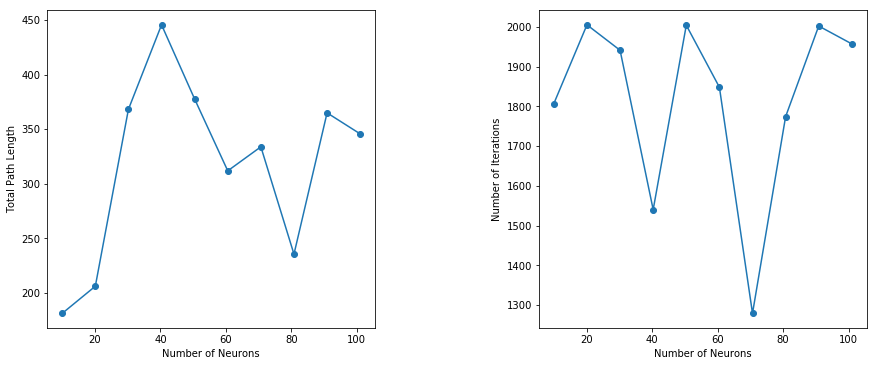

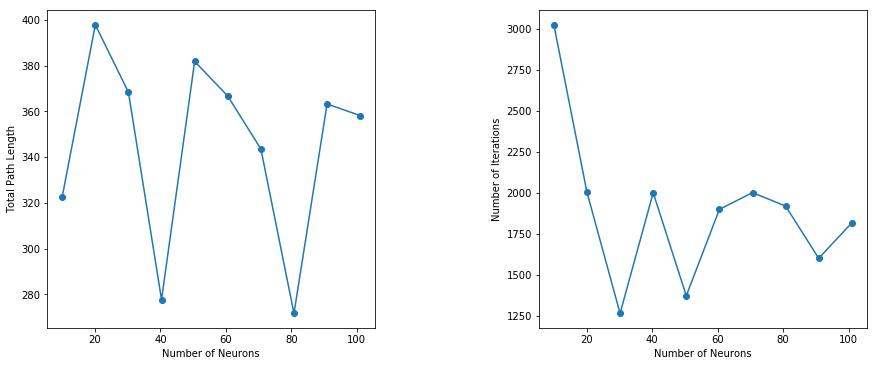

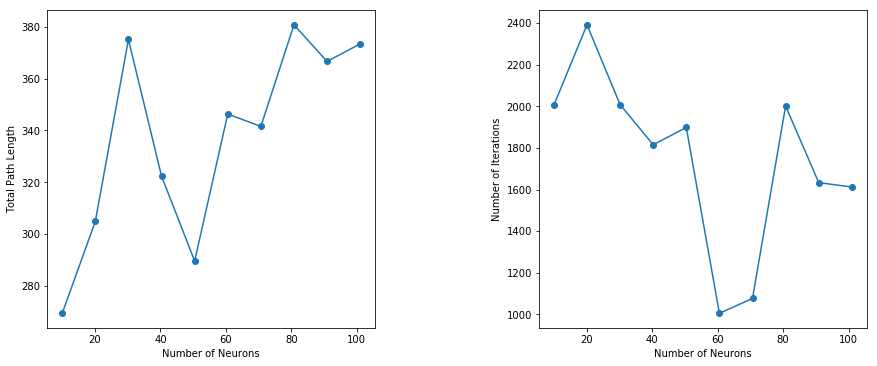

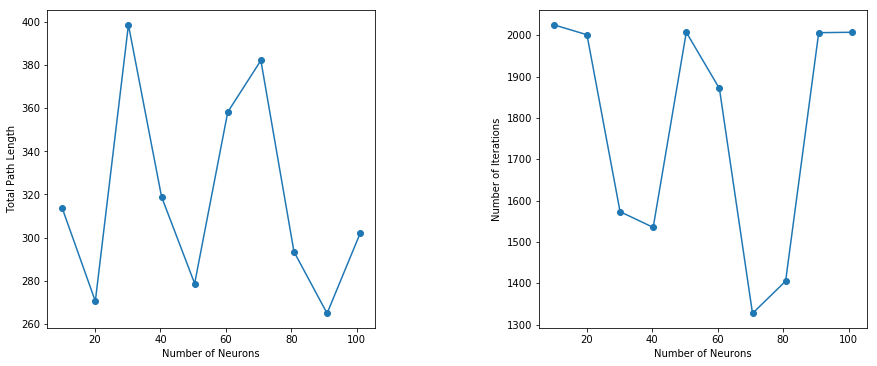

In [11]:
for i in xrange(5):
    #print "Trial: ",i+1
    #print "----------------------"
    length_array=[]
    iteration_array=[]
    for j in xrange(10,101,10):
        #print "Number of neurons: ",j
        #print "-**-"
        iterations,neurons=SOM(epsilon= 0.001,no_cities=10,no_neurons=j).som(noplots=True)
        iteration_array.append(iterations)
        length_array.append(findPathLength(neurons))
    length_array=np.array(length_array)
    iteration_array=np.array(iteration_array)
    no_of_nodes=np.linspace(10,101,10)
    
    figure = plt.figure()
    figure.set_figheight(5)
    figure.set_figwidth(12)

    figure.add_subplot(1, 2, 1)
    plt.tight_layout()
    plt.plot(no_of_nodes,length_array,marker='o')
    plt.subplots_adjust(wspace=.5)
    plt.xlabel('Number of Neurons')
    plt.ylabel('Total Path Length')
    figure.add_subplot(1, 2, 2)
    plt.plot(no_of_nodes,iteration_array,marker='o')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Number of Iterations')
    plt.show()

print ""

### Comments

From the above plots, it can be seen that, 
1. With increase in the number of neurons in the SOM, the *total path length* generaly seems to increase. This can be attributed to the possibility that during the random initialization of the weights, some of the weights are placced in such positions that are outisde the neighbourhood of all the cities. This is more probable when the number of neurons increases. However, when there are just as many neurons as cities, each neuron is ultimately drawn towards their closest city. Thus we get a more optimal path.
2. However, the optimality in the above case comes at a price. With less number of neurons, it generally takes much longer to reach the optimal condition. In most cases, the total iteration required when neuron quantity is ten times the number of cities is about half than what is required when number of neurons equals the number of cities.
3. A best case scenario is mostly observed when the number of neurons is between seven to eight times the number of cities. However, this is not always true